<a href="https://colab.research.google.com/github/voshna123/tensorflow_practice/blob/main/Practice7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import tf_keras

In [2]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.


In [3]:
import tensorflow as tf
import pandas as pd

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-18 04:32:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-18 04:32:41 (74.8 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [6]:
from helper_functions import calculate_results,create_tensorboard_callback

In [7]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [8]:
import os

filenames = [data_dir + "/"+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

#Preprocess Data

In [9]:
def get_lines(filename):
  """
  Reads filename and return the lines of text as a list

  Args:
  filename

  Returns:
  List of lines
  """

  with open(filename, "r") as f:
    return f.read().splitlines()

In [10]:
train_lines = get_lines(filenames[1])
train_lines[0:10]

['###24845963',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .",
 'RESULTS\tWhen 

In [11]:
from inspect import currentframe
def preprocesses_line(filename):
  """
  Returns list of dictionaries
  """

  input_line = get_lines(filename)
  text = []
  category =[]
  line_nums = []
  max_lines =[]


  curr_max= 0

  for line in input_line:
    if not '###' in line:
      if line == "":
        for x in range(curr_max):
          max_lines.append(curr_max)
        continue
      else:
        curr_max += 1
        line_nums.append(line_number)
        line_number += 1
        split = line.split("\t")
        category.append(split[0])
        text.append(split[1])

    else:

      line_number =0
      curr_max = 0


  return {"line_number": line_nums, "text": text, "category": category, "max" :max_lines}

In [12]:
import pandas as pd
test_df = pd.DataFrame(preprocesses_line(filenames[0]))
txt_dict_train = preprocesses_line(filenames[1])
val_df = pd.DataFrame(preprocesses_line(filenames[2]))
train_df = pd.DataFrame(txt_dict_train)

<Axes: ylabel='Frequency'>

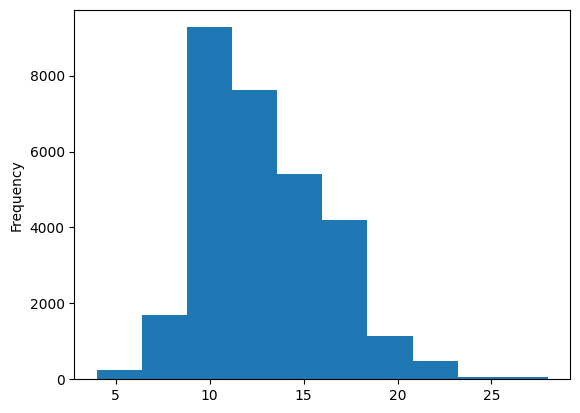

In [13]:
train_df['max'].plot.hist()

## Getting list of sentences

In [14]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

## Encode Labels

In [15]:
import sklearn

encoder = sklearn.preprocessing.OneHotEncoder()

train_onelabels = encoder.fit_transform(train_df['category'].to_numpy().reshape(-1,1))
train_onelabels = train_onelabels.toarray()
test_onelabels = encoder.fit_transform(test_df['category'].to_numpy().reshape(-1,1))
test_onelabels = test_onelabels.toarray()
val_onelabels = encoder.fit_transform(val_df['category'].to_numpy().reshape(-1,1))
val_onelabels = val_onelabels.toarray()

In [16]:
label_encoder = sklearn.preprocessing.LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['category'])
test_labels = label_encoder.fit_transform(test_df['category'])
val_labels = label_encoder.fit_transform(val_df['category'])
train_labels, len(train_labels)


(array([0, 4, 4, ..., 4, 4, 1]), 30135)

In [17]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Getting character level tokens

In [18]:
def split_chars(text):
  return " ".join(list(text))

In [19]:
train_chars = [split_chars(text) for text in train_sentences]
test_chars = [split_chars(text) for text in test_sentences]
val_chars = [split_chars(text) for text in val_sentences]
train_chars[:5]

['T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )   .',
 'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )   .',
 'L i v e r   f u n c t i o n   t e s t s   (   L F T s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 'S u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

## create positional embeddings

In [20]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:10]

(TensorShape([30135, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [21]:
import numpy as np

np.percentile(train_df['max'], 98)

20.0

In [22]:
train_max_one_hot = tf.one_hot(train_df['max'].to_numpy(), depth = 20)
val_max_one_hot = tf.one_hot(val_df['max'].to_numpy(), depth = 20)
test_max_one_hot = tf.one_hot(test_df['max'].to_numpy(), depth = 20)

In [23]:
train_max_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

# Creating char model, line number and max_line model

In [24]:
txt_vectoriser = tf_keras.layers.TextVectorization(max_tokens = 6800,
                                                   output_sequence_length = 55)

txt_vectoriser.adapt(train_sentences)

In [25]:
embedding_layer = tf_keras.layers.Embedding(input_dim = txt_vectoriser.vocabulary_size(),
                                            output_dim = 128,
                                            embeddings_initializer = "uniform",
                                            mask_zero = True)

In [26]:
char_vectoriser = tf_keras.layers.TextVectorization(max_tokens = 60,
                                                    output_sequence_length = 290,
                                                    standardize =None)

char_vectoriser.adapt(train_chars)

In [27]:
embedding_layer_char = tf_keras.layers.Embedding(input_dim = 60,
                                                 output_dim = 25,
                                                 mask_zero = True)

In [28]:
line_n_inputs = tf_keras.layers.Input(shape = (15,), dtype=tf.float32, name = "line_number_inputs")
line_outputs = tf_keras.layers.Dense(32, activation='relu')(line_n_inputs)
line_model = tf_keras.Model(line_n_inputs, line_outputs)

In [29]:
max_lines = tf_keras.layers.Input(shape = (20,), dtype = tf.float32, name = "max_lines")
line_outputs = tf_keras.layers.Dense(32, activation='relu')(max_lines)
max_model = tf_keras.Model(max_lines, line_outputs)

# Creating datasets

In [30]:
char_inputs = tf_keras.layers.Input(shape =(1,), dtype = tf.string, name = "char_input")
char_embeddings = char_vectoriser(char_inputs)
char_embeddings = embedding_layer_char(char_embeddings)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(16))(char_embeddings)
#char_output = tf.keras.layers.GlobalAveragePooling1D()(char_bi_lstm)
char_model = tf_keras.Model(char_inputs, char_bi_lstm)

# Using BERT

In [31]:
import tensorflow_hub as hub
Inputs= tf_keras.layers.Input(shape = (), dtype = tf.string)
preprocess = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
bert = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2",
    trainable=True)

x  = preprocess(Inputs)
x = bert(x)

In [32]:
x

{'pooled_output': <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'keras_layer_1')>,
 'sequence_output': <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
 'encoder_outputs': [<KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 128) dtype=float32

In [33]:
model = tf_keras.Model(Inputs,x)

In [34]:
model.output['default'], char_model.output

(<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'keras_layer_1')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'bidirectional')>)

In [35]:
token_char_concat = tf_keras.layers.Concatenate(name ="token_char_hybrid")([model.output['default'], char_model.output])
z = tf_keras.layers.Dense(256, activation='relu')(token_char_concat)
z = tf_keras.layers.Dropout(0.5)(z)

In [36]:
everything_concat = tf_keras.layers.Concatenate(name = "everthing_combined")([z, line_model.output, max_model.output])

output_layer = tf_keras.layers.Dense(5, activation ='softmax')(everything_concat)

model = tf_keras.Model(inputs =[line_model.input,
                                max_model.input,
                                char_model.input,
                                model.input],
                       outputs = output_layer)

In [ ]:
bert_data = preprocess(train_sentences)

In [ ]:
train_token_char_dataset = tf.data.Dataset.from_tensor_slices((bert_data,train_line_numbers_one_hot, train_max_one_hot,train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_onelabels)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_dataset, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_token_char_dataset = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_max_one_hot,test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_onelabels)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_dataset, test_token_char_labels))

test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_token_char_dataset = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_max_one_hot, val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_onelabels)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_dataset, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)